In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
df = pd.DataFrame(pd.read_excel('./datasci/cleanedup/whl_2025_base.xlsx'))
df.head()

In [ ]:
'''
IDENTIFIERS:
- game_id
- record_id

ENTITIES:
- home_team
- away_team
- home_goalie
- away_goalie

CONTEXT:
- home_off_line
- away_off_line
- home_def_pairing
- away_def_pairing
- went_ot

OUTCOMES:
- home_goals
- away_goals
- home_shots
- away_shots
- home_penalties_committed
- away_penalties_committed

DERIVED METRICS:
- home_xg
- away_xg
- home_max_xg
- away_max_xg
'''

In [15]:
sum_cols = [
    "home_goals", "away_goals",
    "home_shots", "away_shots",
    "home_xg", "away_xg",
    "home_assists", "away_assists",
    "home_penalties_committed", "away_penalties_committed",
    "home_penalty_minutes", "away_penalty_minutes"
]
first_cols = [
    "home_team",
    "away_team",
    "went_ot"
]
agg_dict = {}

for col in sum_cols:
    agg_dict[col] = "sum"

for col in first_cols:
    agg_dict[col] = "first"
games = (
    df
    .groupby("game_id", as_index=False)
    .agg(agg_dict)
)
games.shape

(1312, 16)

In [16]:
games["home_score"] = games["home_goals"]
games["away_score"] = games["away_goals"]

games["goal_diff"] = games["home_score"] - games["away_score"]
games["total_goals"] = games["home_score"] + games["away_score"]

games["shot_diff"] = games["home_shots"] - games["away_shots"]
games["total_shots"] = games["home_shots"] + games["away_shots"]

games


,game_id,home_goals,away_goals,home_shots,away_shots,home_xg,away_xg,home_assists,away_assists,home_penalties_committed,...,away_penalty_minutes,home_team,away_team,went_ot,home_score,away_score,goal_diff,total_goals,shot_diff,total_shots
0,game_0001,1,3,21,24,2.8231,2.7516,2,6,8,...,12,thailand,pakistan,0,1,3,-2,4,-3,45
1,game_0002,3,2,31,27,3.4075,3.0509,4,4,9,...,12,france,morocco,1,3,2,1,5,4,58
2,game_0003,4,3,42,26,4.8049,2.3901,6,6,6,...,24,peru,iceland,1,4,3,1,7,16,68
3,game_0004,0,1,19,16,1.6322,1.6166,0,2,6,...,10,mongolia,saudi_arabia,0,0,1,-1,1,3,35
4,game_0005,4,1,32,42,3.1535,4.7456,7,1,9,...,12,usa,guatemala,0,4,1,3,5,-10,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1307,game_1308,2,0,13,24,1.2708,2.4745,3,0,7,...,10,switzerland,france,0,2,0,2,2,-11,37
1308,game_1309,5,4,29,29,4.2460,2.3279,9,5,2,...,24,netherlands,south_korea,0,5,4,1,9,0,58
1309,game_1310,1,3,21,19,3.0211,2.1164,1,5,6,...,8,uk,uae,0,1,3,-2,4,2,40
1310,game_1311,3,0,18,24,2.4804,1.9921,5,0,6,...,13,brazil,rwanda,0,3,0,3,3,-6,42


In [17]:
home_games = games.copy()

home_games["team"] = home_games["home_team"]
home_games["opponent"] = home_games["away_team"]

home_games["goals_for"] = home_games["home_score"]
home_games["goals_against"] = home_games["away_score"]

home_games["shots_for"] = home_games["home_shots"]
home_games["shots_against"] = home_games["away_shots"]

home_games["xg_for"] = home_games["home_xg"]
home_games["xg_against"] = home_games["away_xg"]

home_games["is_home"] = 1

In [18]:
away_games = games.copy()

away_games["team"] = away_games["away_team"]
away_games["opponent"] = away_games["home_team"]

away_games["goals_for"] = away_games["away_score"]
away_games["goals_against"] = away_games["home_score"]

away_games["shots_for"] = away_games["away_shots"]
away_games["shots_against"] = away_games["home_shots"]

away_games["xg_for"] = away_games["away_xg"]
away_games["xg_against"] = away_games["home_xg"]

away_games["is_home"] = 0

In [19]:
team_games = pd.concat([home_games, away_games], ignore_index=True)
team_games["goal_diff"] = team_games["goals_for"] - team_games["goals_against"]

team_games["win"] = (team_games["goal_diff"] > 0).astype(int)
team_games["loss"] = (team_games["goal_diff"] < 0).astype(int)
team_season = (
    team_games
    .groupby("team", as_index=False)
    .agg(
        games_played = ("team", "count"),
        wins = ("win", "sum"),
        losses = ("loss", "sum"),
        goals_for = ("goals_for", "sum"),
        goals_against = ("goals_against", "sum"),
        shots_for = ("shots_for", "sum"),
        shots_against = ("shots_against", "sum"),
        xg_for = ("xg_for", "sum"),
        xg_against = ("xg_against", "sum"),
        avg_goal_diff = ("goal_diff", "mean"),
        home_games = ("is_home", "sum")
    )
)
team_season["goals_per_game"] = team_season["goals_for"] / team_season["games_played"]
team_season["goals_against_per_game"] = team_season["goals_against"] / team_season["games_played"]

team_season["shot_diff"] = team_season["shots_for"] - team_season["shots_against"]
team_season["xg_diff"] = team_season["xg_for"] - team_season["xg_against"]
team_season["win_pct"] = team_season["wins"] / team_season["games_played"]
team_season["loss_pct"] = team_season["losses"] / team_season["games_played"]

team_season
team_season.sort_values("loss_pct", ascending=False).head()


,team,games_played,wins,losses,goals_for,goals_against,shots_for,shots_against,xg_for,xg_against,avg_goal_diff,home_games,goals_per_game,goals_against_per_game,shot_diff,xg_diff,win_pct,loss_pct
12,mongolia,82,27,55,179,244,2018,2314,187.5990,268.4970,-0.792683,41,2.182927,2.975610,-296,-80.8980,0.329268,0.670732
10,kazakhstan,82,30,52,193,248,1986,1955,209.8053,231.4215,-0.670732,41,2.353659,3.024390,31,-21.6162,0.365854,0.634146
21,rwanda,82,30,52,202,265,2126,2150,223.8094,256.1218,-0.768293,41,2.463415,3.231707,-24,-32.3124,0.365854,0.634146
16,oman,82,35,47,241,283,2176,2287,244.9371,279.4926,-0.512195,41,2.939024,3.451220,-111,-34.5555,0.426829,0.573171
30,usa,82,35,47,240,287,2171,2400,247.3928,281.6973,-0.573171,41,2.926829,3.500000,-229,-34.3045,0.426829,0.573171


In [20]:
home_wins = games[games['home_goals'] > games['away_goals']]
home_wins.describe()

,home_goals,away_goals,home_shots,away_shots,home_xg,away_xg,home_assists,away_assists,home_penalties_committed,away_penalties_committed,home_penalty_minutes,away_penalty_minutes,went_ot,home_score,away_score,goal_diff,total_goals,shot_diff,total_shots
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,3.991892,1.797297,28.333784,24.908108,3.274671,2.630231,6.221622,2.808108,5.805405,7.179730,11.832432,14.677027,0.202703,3.991892,1.797297,2.194595,5.789189,3.425676,53.241892
std,1.639314,1.337294,6.596074,6.186299,0.930712,0.777341,2.929403,2.204299,2.707174,2.936656,5.614019,6.137333,0.402285,1.639314,1.337294,1.518483,2.577910,8.595158,9.469965
min,1.000000,0.000000,10.000000,8.000000,1.094200,0.565100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,-22.000000,30.000000
25%,3.000000,1.000000,24.000000,21.000000,2.651400,2.080475,4.000000,1.000000,4.000000,5.000000,8.000000,10.000000,0.000000,3.000000,1.000000,1.000000,4.000000,-2.000000,47.000000
50%,4.000000,2.000000,28.000000,24.000000,3.182250,2.549250,6.000000,2.000000,6.000000,7.000000,12.000000,14.000000,0.000000,4.000000,2.000000,2.000000,5.000000,3.000000,53.000000
75%,5.000000,3.000000,32.000000,29.000000,3.818400,3.099200,8.000000,4.000000,7.000000,9.000000,16.000000,18.000000,0.000000,5.000000,3.000000,3.000000,7.000000,9.000000,59.000000
max,11.000000,7.000000,51.000000,48.000000,7.347200,5.888500,19.000000,11.000000,16.000000,19.000000,32.000000,38.000000,1.000000,11.000000,7.000000,8.000000,15.000000,34.000000,95.000000


In [21]:
'''
# TODO: Calculate 'Home Multiplier' by comparing Home xG/60 vs Away xG/60 across the league.
# TODO: Apply a 'Neutrality Filter' to penalize home-heavy schedules in the rankings.

# --- LOGIC FOR went_ot (The Volatility Filter) ---
# 1. Regulation Performance: Use this to isolate 'Regulation Goal Differential'.
#    A team winning 5-0 in regulation is significantly stronger than a team
#    winning 1-0 in OT. The former shows dominance; the latter shows a coin-flip.
#
# 2. 'The Paper Tiger' Check: Identify teams with high standings but high OT win rates.
#    If a team relies on OT/Shootouts, their Power Ranking should be ADJUSTED DOWN
#    as OT results are less repeatable than 5-on-5 play.
#
# 3. 'The Resilience' Factor: Boost teams with high OT Loss counts.
#    In the standings, they look like losers (0 wins), but in reality,
#    they are competitive enough to hold elite teams to a draw for 60 minutes.
#
# 4. Usage Normalization: Since OT adds extra 'toi', always use 'per 60 minutes'
#    rates (e.g., xG/60) to ensure OT minutes don't artificially inflate total stats.

# --- LOGIC FOR home_off_line (The Roster Strength Factor) ---
# 1. Roster Depth: Compare 'first_off' vs 'second_off' xG/60.
#    - 'One-Line Wonders': Teams with a huge drop-off in quality (e.g., 1st line 3.0 xG, 2nd line 0.5 xG).
#    - 'Balanced Giants': Teams where both lines produce consistently.
#    ACTION: Reward 'Balanced' teams with a higher stability score in rankings.
#
# 2. Situational Power: Isolate 'PP_up' (Power Play) records.
#    - Standing might be low, but if 'PP_up' xG/60 is top 5, they are a 'Danger Team'.
#    ACTION: Add a 'Special Teams Grade' to the final Power Ranking.
#
# 3. 5-on-5 Purity: Filter for 'first_off' and 'second_off' only to find 'Even-Strength' dominance.
#    - This is the most repeatable part of hockey.
#    ACTION: Use Even-Strength xG Differential as 50% of the total Power Ranking weight.
#
# 4. Tactical Matchups: Link with 'away_def_pairing' to see which lines 'crush' weaker defenders.
#    - Identify teams that successfully hunt mismatches (e.g., first_off vs. opponent's second_def).

# --- LOGIC FOR home_def_pairing (The Shutdown Metric) ---
# 1. Shutdown Quality: Calculate 'xG Allowed per 60' for each pairing.
#    A team's 'Defensive Rank' should be heavily weighted by the first_def unit.
#
# 2. Defensive Depth: Measure the 'Reliability Gap' between 1st and 2nd pairs.
#    Teams with a strong second_def are 'Tournament Hardened' and harder to exploit.
#
# 3. PK Specialist Rank: Filter for 'PP_kill_dwn'.
#    Identify teams that effectively suppress xG even when man-down.
#    High PK efficiency is a major signal for 'Playoff Ready' power rankings.
#
# 4. Goal-Save Delta: Compare 'Actual Goals Allowed' vs 'xG Allowed' per pairing.
#    If a pairing allows high xG but zero goals, the goalie is 'bailing them out'.




'''

"\n# TODO: Calculate 'Home Multiplier' by comparing Home xG/60 vs Away xG/60 across the league.\n# TODO: Apply a 'Neutrality Filter' to penalize home-heavy schedules in the rankings.\n\n# --- LOGIC FOR went_ot (The Volatility Filter) ---\n# 1. Regulation Performance: Use this to isolate 'Regulation Goal Differential'.\n#    A team winning 5-0 in regulation is significantly stronger than a team\n#    winning 1-0 in OT. The former shows dominance; the latter shows a coin-flip.\n#\n# 2. 'The Paper Tiger' Check: Identify teams with high standings but high OT win rates.\n#    If a team relies on OT/Shootouts, their Power Ranking should be ADJUSTED DOWN\n#    as OT results are less repeatable than 5-on-5 play.\n#\n# 3. 'The Resilience' Factor: Boost teams with high OT Loss counts.\n#    In the standings, they look like losers (0 wins), but in reality,\n#    they are competitive enough to hold elite teams to a draw for 60 minutes.\n#\n# 4. Usage Normalization: Since OT adds extra 'toi', alway

In [23]:
home_ot = games[['home_team', 'went_ot']].rename(columns={'home_team': 'team'})
away_ot = games[['away_team', 'went_ot']].rename(columns={'away_team': 'team'})

# Combine both lists and sum the OT occurrences
team_ot_counts = pd.concat([home_ot, away_ot]).groupby('team')['went_ot'].sum().reset_index()
team_ot_counts.columns = ['team', 'ot_games_count']

# Sort by the number of OT games
team_ot_counts = team_ot_counts.sort_values(by='ot_games_count', ascending=False)
print(team_ot_counts)

            team  ot_games_count
28           uae              28
20   philippines              26
31       vietnam              25
11        mexico              22
19          peru              22
3       ethiopia              21
13       morocco              21
29            uk              20
24     singapore              20
30           usa              20
18        panama              19
4         france              19
6      guatemala              19
26   switzerland              19
2          china              18
12      mongolia              18
1         canada              18
21        rwanda              18
22  saudi_arabia              18
14   netherlands              18
7        iceland              17
17      pakistan              16
25   south_korea              15
9      indonesia              15
10    kazakhstan              14
16          oman              14
0         brazil              13
8          india              13
27      thailand              13
15   new_z

In [24]:
team_games["reg_win"] = ((team_games["goal_diff"] > 0) & (team_games["went_ot"] == 0)).astype(int)
team_games["ot_win"] = ((team_games["goal_diff"] > 0) & (team_games["went_ot"] == 1)).astype(int)
team_games["ot_loss"] = ((team_games["goal_diff"] < 0) & (team_games["went_ot"] == 1)).astype(int)
team_games["reg_loss"] = ((team_games["goal_diff"] < 0) & (team_games["went_ot"] == 0)).astype(int)
team_season = (
    team_games
    .groupby("team", as_index=False)
    .agg(
        games_played = ("team", "count"),
        reg_wins = ("reg_win", "sum"),
        ot_wins = ("ot_win", "sum"),
        ot_losses = ("ot_loss", "sum"),
        reg_losses = ("reg_loss", "sum"),
        goals_for = ("goals_for", "sum"),
        goals_against = ("goals_against", "sum"),
        xg_for = ("xg_for", "sum"),
        xg_against = ("xg_against", "sum"),
        total_ot_games = ("went_ot", "sum")
    )
)


In [30]:
# 3. Calculate the New Metrics (The Logic Check)
# Regulation Performance (Pure Dominance)
team_season["reg_win_pct"] = team_season["reg_wins"] / team_season["games_played"]

# 'The Paper Tiger' Check (What % of their wins are 'coin-flips'?)
# High ratio = Adjusted Down
team_season["ot_reliance_ratio"] = team_season["ot_wins"] / (team_season["reg_wins"] + team_season["ot_wins"] + 1e-6)

# 'The Resilience' Factor (High OT losses = Competitiveness)
# High ratio = Adjusted Up
team_season["resilience_factor"] = team_season["ot_losses"] / (team_season["reg_losses"] + team_season["ot_losses"] + 1e-6)

# 4. Usage Normalization (Per 60)
# Assuming OT adds roughly 5 mins on average to a game
team_season["total_minutes"] = (team_season["games_played"] * 60) + (team_season["total_ot_games"] * 5)
team_season["xg_for_per_60"] = (team_season["xg_for"] / team_season["total_minutes"]) * 60
team_season["xg_against_per_60"] = (team_season["xg_against"] / team_season["total_minutes"]) * 60

team_season.sort_values("reg_win_pct", ascending=False)

,team,games_played,reg_wins,ot_wins,ot_losses,reg_losses,goals_for,goals_against,xg_for,xg_against,total_ot_games,reg_win_pct,ot_reliance_ratio,resilience_factor,total_minutes,xg_for_per_60,xg_against_per_60
0,brazil,82,51,7,6,18,276,189,272.4793,221.8266,13,0.621951,0.120690,0.250000,4985,3.279590,2.669929
27,thailand,82,44,6,7,25,294,248,294.7369,221.6617,13,0.536585,0.120000,0.218750,4985,3.547485,2.667944
14,netherlands,82,42,12,6,22,243,174,242.4986,201.8032,18,0.512195,0.222222,0.214286,5010,2.904175,2.416805
8,india,82,42,7,6,27,221,193,239.3359,237.9323,13,0.512195,0.142857,0.181818,4985,2.880673,2.863779
17,pakistan,82,41,8,8,25,263,212,284.7034,233.4620,16,0.500000,0.163265,0.242424,5000,3.416441,2.801544
19,peru,82,38,14,8,22,256,178,244.5499,214.9336,22,0.463415,0.269231,0.266667,5030,2.917096,2.563820
7,iceland,82,38,8,9,27,238,209,230.0624,248.6737,17,0.463415,0.173913,0.250000,5005,2.757991,2.981103
2,china,82,36,11,7,28,239,193,255.9170,220.9786,18,0.439024,0.234043,0.200000,5010,3.064874,2.646450
18,panama,82,36,10,9,27,255,213,257.4552,241.3937,19,0.439024,0.217391,0.250000,5015,3.080222,2.888060
23,serbia,82,35,6,6,35,269,264,277.2881,264.1742,12,0.426829,0.146341,0.146341,4980,3.340820,3.182822


In [33]:
# 1. Total wins (Reg + OT) for the standard Win %
team_games["total_win"] = (team_games["goal_diff"] > 0).astype(int)

# 2. Updated Aggregation
team_season = (
    team_games
    .groupby("team", as_index=False)
    .agg(
        games_played = ("team", "count"),
        total_wins = ("total_win", "sum"),     # For standard win_pct
        reg_wins = ("reg_win", "sum"),         # For pure dominance
        ot_wins = ("ot_win", "sum"),           # For luck factor
        ot_losses = ("ot_loss", "sum"),        # For resilience
        reg_losses = ("reg_loss", "sum"),      # For comparison
    )
)

# 3. Calculate the side-by-side rates
team_season["win_pct"] = team_season["total_wins"] / team_season["games_played"]
team_season["reg_win_pct"] = team_season["reg_wins"] / team_season["games_played"]

# 4. Calculate the 'Deception Gap'
team_season['deception_gap'] = team_season['win_pct'] - team_season['reg_win_pct']

# Display the comparison
print(team_season[['team', 'win_pct', 'reg_win_pct', 'deception_gap']].sort_values(by='deception_gap', ascending=False))

            team   win_pct  reg_win_pct  deception_gap
28           uae  0.463415     0.268293       0.195122
19          peru  0.634146     0.463415       0.170732
20   philippines  0.524390     0.365854       0.158537
31       vietnam  0.475610     0.317073       0.158537
14   netherlands  0.658537     0.512195       0.146341
6      guatemala  0.512195     0.378049       0.134146
11        mexico  0.463415     0.329268       0.134146
2          china  0.573171     0.439024       0.134146
22  saudi_arabia  0.475610     0.341463       0.134146
18        panama  0.560976     0.439024       0.121951
26   switzerland  0.439024     0.317073       0.121951
21        rwanda  0.365854     0.243902       0.121951
13       morocco  0.451220     0.329268       0.121951
30           usa  0.426829     0.304878       0.121951
3       ethiopia  0.524390     0.414634       0.109756
7        iceland  0.560976     0.463415       0.097561
4         france  0.451220     0.353659       0.097561
17      pa

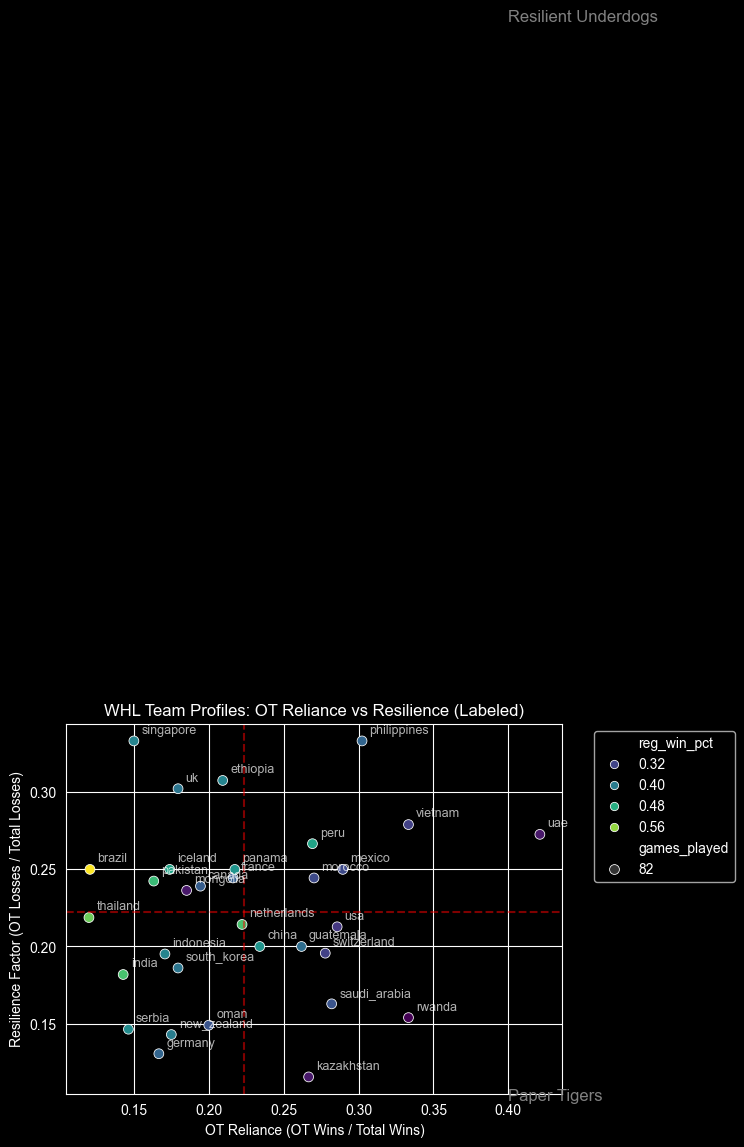

In [29]:
# Create the scatter plot
plot = sns.scatterplot(
    data=team_season,
    x='ot_reliance_ratio',
    y='resilience_factor',
    hue='reg_win_pct',
    size='games_played',
    palette='viridis',
    sizes=(50, 400)
)

# Add team names as labels
for i in range(team_season.shape[0]):
    plt.text(
        x=team_season.ot_reliance_ratio[i] + 0.005,
        y=team_season.resilience_factor[i] + 0.005,
        s=team_season.team[i],
        fontsize=9,
        alpha=0.7
    )

# Add quadrants for easier analysis
plt.axvline(team_season['ot_reliance_ratio'].mean(), color='red', linestyle='--', alpha=0.5)
plt.axhline(team_season['resilience_factor'].mean(), color='red', linestyle='--', alpha=0.5)

# Label the Quadrants
plt.text(0.4, 0.8, "Resilient Underdogs", color='gray', fontsize=12)
plt.text(0.4, 0.1, "Paper Tigers", color='gray', fontsize=12)

plt.title("WHL Team Profiles: OT Reliance vs Resilience (Labeled)")
plt.xlabel("OT Reliance (OT Wins / Total Wins)")
plt.ylabel("Resilience Factor (OT Losses / Total Losses)")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

In [39]:
# 1. Ensure the underlying team_games has everything
# (This assumes team_games already has goals_for, shots_for, xg_for from your earlier concat)

# 2. Re-run the Master Aggregation
team_season = (
    team_games
    .groupby("team", as_index=False)
    .agg(
        games_played = ("team", "count"),
        total_wins = ("total_win", "sum"),
        reg_wins = ("reg_win", "sum"),
        ot_wins = ("ot_win", "sum"),
        ot_losses = ("ot_loss", "sum"),
        reg_losses = ("reg_loss", "sum"),
        shots_for = ("shots_for", "sum"),       # Added this back
        shots_against = ("shots_against", "sum"), # Added this back
        xg_for = ("xg_for", "sum"),
        xg_against = ("xg_against", "sum")
    )
)

# 3. Re-calculate the rates
team_season["win_pct"] = team_season["total_wins"] / team_season["games_played"]
team_season["reg_win_pct"] = team_season["reg_wins"] / team_season["games_played"]
team_season["deception_gap"] = team_season["win_pct"] - team_season["reg_win_pct"]
team_season["xg_diff"] = team_season["xg_for"] - team_season["xg_against"]

# 4. Now the Corsi (Shot Share) calculation will work!
team_season["corsi_for_pct"] = team_season["shots_for"] / (team_season["shots_for"] + team_season["shots_against"])
# 1. Calculate the League-Wide Benchmarks (The Limits)
corsi_mean = team_season["corsi_for_pct"].mean()
gap_mean = team_season["deception_gap"].mean()

# 2. Print the Threshold Report
print("--- WHL MODEL CLASSIFICATION LIMITS ---")
print(f"Corsi Mean (Possession Threshold): {corsi_mean:.4f}")
print(f"Deception Mean (Luck Threshold):     {gap_mean:.4f}")
print("-" * 40)

# 3. Define the Logic
def identify_profile(row):
    # Quadrant 1: Low Possession, High OT Luck
    if row["corsi_for_pct"] < corsi_mean and row["deception_gap"] > gap_mean:
        return "Double Fraud"
    # Quadrant 2: High Possession, Low OT Luck (Dominant)
    if row["corsi_for_pct"] > corsi_mean and row["deception_gap"] < gap_mean:
        return "Pure Juggernaut"
    # Quadrant 3: High Possession, High OT Luck (Can't finish in 60)
    if row["corsi_for_pct"] > corsi_mean and row["deception_gap"] > gap_mean:
        return "Finishing Problem"
    # Quadrant 4: Low Possession, Low OT Luck
    return "Underdog"

# 4. Apply and Display
team_season["team_profile"] = team_season.apply(identify_profile, axis=1)

# Display results sorted by Deception Gap to highlight the Frauds
analysis_cols = ['team', 'win_pct', 'reg_win_pct', 'deception_gap', 'corsi_for_pct', 'team_profile']


print("Success! Data aggregated. Preview of top Corsi teams:")
print(team_season[['team', 'corsi_for_pct', 'deception_gap','team_profile']].sort_values('corsi_for_pct', ascending=True))

--- WHL MODEL CLASSIFICATION LIMITS ---
Corsi Mean (Possession Threshold): 0.5001
Deception Mean (Luck Threshold):     0.1098
----------------------------------------
Success! Data aggregated. Preview of top Corsi teams:
            team  corsi_for_pct  deception_gap       team_profile
28           uae       0.454143       0.195122       Double Fraud
12      mongolia       0.465836       0.060976           Underdog
24     singapore       0.472739       0.073171           Underdog
3       ethiopia       0.473128       0.109756       Double Fraud
7        iceland       0.474491       0.097561           Underdog
30           usa       0.474951       0.121951       Double Fraud
22  saudi_arabia       0.475690       0.134146       Double Fraud
31       vietnam       0.487041       0.158537       Double Fraud
16          oman       0.487564       0.085366           Underdog
26   switzerland       0.488106       0.121951       Double Fraud
13       morocco       0.488310       0.121951       

In [ ]:
a# --- LOGIC FOR AWAY COLUMNS (Road Resilience & System Strength) ---
# 1. Road Resilience Score: Aggregate team xG when playing as 'away_team'.
#    - Compare 'Away xG/60' vs 'Home xG/60'.
#    - ACTION: Teams with the smallest "Home-Road Gap" get a Reliability Bonus.
#      They are 'System-Strong' and play well regardless of environment.
#
# 2. Defensive Opponent-Adjustment: Use away_def_pairing to 'weight' offensive success.
#    - Scoring against an opponent's 'first_def' is worth more Power Points
#      than scoring against their 'second_def'.
#    - ACTION: Create a 'Difficulty-Adjusted Goal' metric.
#
# 3. The "Last Change" Penalty: On the road, teams cannot control line matchups.
#    - If a team's 'away_off_line' (1st) still dominates while being 'hunted'
#      by the home coach, they are a Top-Tier Juggernaut.
#
# 4. Data Normalization: Combine Home and Away stats into a single 'Neutral Table'.
#    - This ensures a team's Power Ranking is based on their WHOLE season,
#      not just a favorable home schedule.

In [ ]:

# --- LOGIC FOR GOALIE COLUMNS (The Gatekeeper Factor) ---
# 1. GSAx (Goals Saved Above Expected): Compare 'Actual Goals Allowed' vs 'Total xG'.
#    - Formula: GSAx = Total xG - Actual Goals.
#    - ACTION: High GSAx = Elite Goalie. Low GSAx = Weak Link.
#
# 2. Standings vs. Process: Identify teams 'carried' by their goalie.
#    - If a team wins despite being out-shot (low xG share), their rank is FRAGILE.
#    - ACTION: Weight 'Team xG' higher than 'Actual Wins' to find sustainable power.
#
# 3. Goalie Split: Check if a team has a clear 'Starter' vs 'Backup'.
#    - Does the team's Win % drop significantly when the backup goalie is in?
#    - ACTION: Create a 'Roster Reliability' score based on the gap between goalies.
#
# 4. The 'Sieve' Alert: Flag teams with high xG suppression (great defense)
#    but high Goals Against (bad goalie). These are 'Sleepers' if they swap goalies.

In [ ]:
# --- LOGIC FOR TOI (The Normalization Key) ---
# 1. Rate Normalization: NEVER use raw xG or Goals for rankings.
#    Always calculate (Stat / toi) * 3600 to get the 'Per 60' rate.
#
# 2. Fatigue Analysis: Track total TOI for 'first_def' and 'first_off'.
#    Teams with extreme workloads for top units should get a 'Sustainability Penalty'
#    in long-term power rankings.
#
# 3. Small Sample Filter: Ignore or down-weight lines with less than
#    a certain threshold of total TOI (e.g., 500 seconds) to avoid 'fluke' stats.
#
# 4. Efficiency Mapping: Combine TOI with xG to see which lines are the
#    most 'lethal' per minute played.

In [ ]:
# --- LOGIC FOR SHOTS & ASSISTS (Style & Luck Filter) ---
# 1. Shooting Percentage: (home_goals / home_shots).
#    - Identify 'Sustainability': If a team's shooting % is way above the league average,
#      expect their Power Ranking to drop later (regression).
#
# 2. Playmaking Grade: (home_assists / home_goals).
#    - High ratios indicate 'System Teams' with high puck movement.
#    - Low ratios indicate 'Individualist Teams' (reliant on solo efforts/turnovers).
#
# 3. Chaos Generator: Identify teams with high 'Shots per 60' but low xG.
#    - These teams play a 'dirty' game—relying on rebounds and volume rather than skill.
#
# 4. Assist Map: Link assists to off_line.
#    - Does the 1st line rely on assists while the 2nd line scores solo?
#    - ACTION: Use this to determine which line is easier to 'scout' and shut down.

In [ ]:
# --- LOGIC FOR PENALTIES (The Discipline & Chaos Metric) ---
# 1. Discipline Rating: Calculate 'Penalty Minutes per 60'.
#    - Identify teams that 'beat themselves'. A high-penalizing team
#      should have their Power Score docked for 'Unreliability'.
#
# 2. Special Teams Exposure: Compare 'home_penalties' vs 'away_penalties'.
#    - If away_penalties >> home_penalties, the team is mentally fragile on the road.
#
# 3. Penalty-Adjusted xG: Create a 'Clean-Play xG' by filtering out records
#    where home_penalty == 1. This shows how good a team is when playing fair.
#
# 4. The 'Instigator' Factor: Does a team draw more penalties than they take?
#    - Compare 'home_penalties' vs 'away_penalties' in the same game.
#    - Teams that 'draw' penalties have high 'Functional Aggression'.

In [ ]:
--- LOGIC FOR went_ot (The Volatility Filter) ---
# 1. Regulation Performance: Use this to isolate 'Regulation Goal Differential'.
#    A team winning 5-0 in regulation is significantly stronger than a team
#    winning 1-0 in OT. The former shows dominance; the latter shows a coin-flip.
#
# 2. 'The Paper Tiger' Check: Identify teams with high standings but high OT win rates.
#    If a team relies on OT/Shootouts, their Power Ranking should be ADJUSTED DOWN
#    as OT results are less repeatable than 5-on-5 play.
#
# 3. 'The Resilience' Factor: Boost teams with high OT Loss counts.
#    In the standings, they look like losers (0 wins), but in reality,
#    they are competitive enough to hold elite teams to a draw for 60 minutes.
#
# 4. Usage Normalization: Since OT adds extra 'toi', always use 'per 60 minutes'
#    rates (e.g., xG/60) to ensure OT minutes don't artificially inflate total stats.

 --- LOGIC FOR home_off_line (The Roster Strength Factor) ---
# 1. Roster Depth: Compare 'first_off' vs 'second_off' xG/60.
#    - 'One-Line Wonders': Teams with a huge drop-off in quality (e.g., 1st line 3.0 xG, 2nd line 0.5 xG).
#    - 'Balanced Giants': Teams where both lines produce consistently.
#    ACTION: Reward 'Balanced' teams with a higher stability score in rankings.
#
# 2. Situational Power: Isolate 'PP_up' (Power Play) records.
#    - Standing might be low, but if 'PP_up' xG/60 is top 5, they are a 'Danger Team'.
#    ACTION: Add a 'Special Teams Grade' to the final Power Ranking.
#
# 3. 5-on-5 Purity: Filter for 'first_off' and 'second_off' only to find 'Even-Strength' dominance.
#    - This is the most repeatable part of hockey.
#    ACTION: Use Even-Strength xG Differential as 50% of the total Power Ranking weight.
#
# 4. Tactical Matchups: Link with 'away_def_pairing' to see which lines 'crush' weaker defenders.
#    - Identify teams that successfully hunt mismatches (e.g., first_off vs. opponent's second_def).
# --- LOGIC FOR AWAY COLUMNS (Road Resilience & System Strength) ---
# 1. Road Resilience Score: Aggregate team xG when playing as 'away_team'.
#    - Compare 'Away xG/60' vs 'Home xG/60'.
#    - ACTION: Teams with the smallest "Home-Road Gap" get a Reliability Bonus.
#      They are 'System-Strong' and play well regardless of environment.
#
# 2. Defensive Opponent-Adjustment: Use away_def_pairing to 'weight' offensive success.
#    - Scoring against an opponent's 'first_def' is worth more Power Points
#      than scoring against their 'second_def'.
#    - ACTION: Create a 'Difficulty-Adjusted Goal' metric.
#
# 3. The "Last Change" Penalty: On the road, teams cannot control line matchups.
#    - If a team's 'away_off_line' (1st) still dominates while being 'hunted'
#      by the home coach, they are a Top-Tier Juggernaut.
#
# 4. Data Normalization: Combine Home and Away stats into a single 'Neutral Table'.
#    - This ensures a team's Power Ranking is based on their WHOLE season,
#      not just a favorable home schedule.

In [42]:
# 1. Calculate xG/60 for each offensive line
line_stats = df.groupby(['home_team', 'home_off_line']).agg(
    total_xg = ('home_xg', 'sum'),
    total_toi = ('toi', 'sum')
).reset_index()

line_stats['xg_60'] = (line_stats['total_xg'] / line_stats['total_toi']) * 60

# 2. Pivot to compare lines
roster_pivot = line_stats.pivot(index='home_team', columns='home_off_line', values='xg_60')

# 3. Calculate 'Purity' (Average of top 2 lines) and 'Stability' (The Gap)
roster_pivot['five_on_five_purity'] = (roster_pivot['first_off'] + roster_pivot['second_off']) / 2
roster_pivot['roster_stability_ratio'] = roster_pivot['first_off'] / (roster_pivot['second_off'] + 1e-6)

print("--- PILLAR 1: 5-on-5 PURITY & STABILITY ---")
print(roster_pivot[['five_on_five_purity', 'roster_stability_ratio']].sort_values('five_on_five_purity', ascending=False).head())

--- PILLAR 1: 5-on-5 PURITY & STABILITY ---
home_off_line  five_on_five_purity  roster_stability_ratio
home_team                                                 
thailand                  0.049432                0.995294
pakistan                  0.048831                1.028804
brazil                    0.048609                0.941392
south_korea               0.047373                1.108089
serbia                    0.046142                1.103965


In [44]:
# --- PRETEXT: AUTO-CALIBRATING ROSTER DEPTH ---
# Instead of guessing that a 1.5 ratio is 'Top Heavy', this code
# looks at the entire league's distribution and labels the
# outliers. This ensures we ALWAYS find the most top-heavy teams.

# 1. Calculate the actual median ratio for the league
median_stability = roster_pivot['roster_stability_ratio'].median()
median_purity = roster_pivot['five_on_five_purity'].median()

print(f"League Average Stability Ratio: {median_stability:.2f}")

# 2. Re-classify using Relative Thresholds
def classify_offense_dynamic(row):
    # Above average production?
    is_high_scoring = row['five_on_five_purity'] > median_purity
    # More top-heavy than the average team?
    is_top_heavy = row['roster_stability_ratio'] > median_stability

    if is_high_scoring:
        return "Balanced Giant" if not is_top_heavy else "One-Line Wonder"
    else:
        return "Deep but Weak" if not is_top_heavy else "Top-Heavy Underdog"

roster_pivot['off_identity'] = roster_pivot.apply(classify_offense_dynamic, axis=1)

# 3. Check the distribution
print(roster_pivot['off_identity'].value_counts())

League Average Stability Ratio: 1.07
off_identity
Balanced Giant        10
Top-Heavy Underdog    10
Deep but Weak          6
One-Line Wonder        6
Name: count, dtype: int64


In [46]:
# 1. Calculate medians for dynamic labeling
# We use the median so that exactly half the league is 'High Scoring'
# and half is 'Top Heavy' (relatively speaking).
median_purity = roster_pivot['five_on_five_purity'].median()
median_stability = roster_pivot['roster_stability_ratio'].median()

# 2. Engineering the Label Column
def classify_offense_dynamic(row):
    # Above average production?
    is_high_scoring = row['five_on_five_purity'] > median_purity
    # More top-heavy than the average team?
    is_top_heavy = row['roster_stability_ratio'] > median_stability

    if is_high_scoring:
        # High scoring + Balanced depth
        if not is_top_heavy:
            return "Balanced Giant"
        # High scoring + Reliance on 1st line
        else:
            return "One-Line Wonder"
    else:
        # Low scoring + Balanced depth
        if not is_top_heavy:
            return "Deep but Weak"
        # Low scoring + Reliance on 1st line
        else:
            return "Top-Heavy Underdog"

# Apply the labels to a new feature column
roster_pivot['off_identity'] = roster_pivot.apply(classify_offense_dynamic, axis=1)

# 3. Print the engineered feature set
print("--- OFFENSIVE FEATURE ENGINEERING: TEXT LABELS ---")
print(roster_pivot[['five_on_five_purity', 'roster_stability_ratio', 'off_identity']].sort_values('five_on_five_purity', ascending=False))

--- OFFENSIVE FEATURE ENGINEERING: TEXT LABELS ---
home_off_line  five_on_five_purity  roster_stability_ratio        off_identity
home_team                                                                     
thailand                  0.049432                0.995294      Balanced Giant
pakistan                  0.048831                1.028804      Balanced Giant
brazil                    0.048609                0.941392      Balanced Giant
south_korea               0.047373                1.108089     One-Line Wonder
serbia                    0.046142                1.103965     One-Line Wonder
china                     0.043955                1.037466      Balanced Giant
oman                      0.043165                1.044237      Balanced Giant
uk                        0.042958                1.062849      Balanced Giant
usa                       0.042417                1.369338     One-Line Wonder
mexico                    0.041958                1.055937      Balanced Giant
s

In [47]:
# --- FEATURE ENGINEERING: DEFENSIVE & GOALIE IDENTITY ---

# 1. Aggregate Defensive Data
# We focus on 'first_def' as they face the highest quality competition
def_stats = df.groupby(['home_team', 'home_def_pairing']).agg(
    xg_against = ('away_xg', 'sum'),
    goals_against = ('away_goals', 'sum'),
    total_toi = ('toi', 'sum')
).reset_index()

# 2. Calculate Normalized Rates
def_stats['xGA_60'] = (def_stats['xg_against'] / def_stats['total_toi']) * 60
def_stats['actual_GA_60'] = (def_stats['goals_against'] / def_stats['total_toi']) * 60

# 3. Engineer the 'Goalie Factor'
# (Actual - Expected). Negative means the goalie saved more than expected.
def_stats['goalie_factor'] = def_stats['actual_GA_60'] - def_stats['xGA_60']

# 4. Set Thresholds for Labeling
shutdown_unit = def_stats[def_stats['home_def_pairing'] == 'first_def'].set_index('home_team')
median_xGA = shutdown_unit['xGA_60'].median()

# 5. Engineering the Text Label Column
def classify_goalie_performance(row):
    # System Check
    is_steel_wall = row['xGA_60'] < median_xGA

    # Goalie Check
    if row['goalie_factor'] < -0.2:
        goalie_label = "Goalie Hero"
    elif row['goalie_factor'] > 0.2:
        goalie_label = "Goalie Vulnerable"
    else:
        goalie_label = "Standard Support"

    system_label = "Steel Wall" if is_steel_wall else "Leaky System"
    return f"{system_label} ({goalie_label})"

shutdown_unit['def_identity'] = shutdown_unit.apply(classify_goalie_performance, axis=1)

# 6. Display the Results
print("--- DEFENSIVE FEATURE ENGINEERING: GOALIE LABELS ---")
print(shutdown_unit[['xGA_60', 'goalie_factor', 'def_identity']].sort_values('goalie_factor'))

--- DEFENSIVE FEATURE ENGINEERING: GOALIE LABELS ---
                xGA_60  goalie_factor                     def_identity
home_team                                                             
new_zealand   0.037858      -0.013307  Leaky System (Standard Support)
philippines   0.039356      -0.012836  Leaky System (Standard Support)
india         0.035528      -0.010133  Leaky System (Standard Support)
uk            0.038415      -0.008084  Leaky System (Standard Support)
ethiopia      0.038831      -0.007448  Leaky System (Standard Support)
pakistan      0.032840      -0.006807    Steel Wall (Standard Support)
netherlands   0.032750      -0.006186    Steel Wall (Standard Support)
serbia        0.041343      -0.005977  Leaky System (Standard Support)
kazakhstan    0.038104      -0.005700  Leaky System (Standard Support)
switzerland   0.029119      -0.004320    Steel Wall (Standard Support)
panama        0.034441      -0.002901    Steel Wall (Standard Support)
thailand      0.035900  

In [49]:
# --- FEATURE ENGINEERING: THE TEAM DNA SYNTHESIS ---

# 1. Merge the Offensive and Defensive identities
# We join the two pivoted/engineered dataframes on the team name
team_dna_report = roster_pivot[['off_identity', 'five_on_five_purity']].merge(
    shutdown_unit[['def_identity', 'xGA_60', 'goalie_factor']],
    left_index=True,
    right_index=True
)

# 2. Engineer the 'Strategic Archetype' Label
# This is a high-level feature for executive summaries
def label_archetype(row):
    if row['off_identity'] == "Balanced Giant" and "Steel Wall" in row['def_identity']:
        return "Complete Contender"
    elif row['off_identity'] == "One-Line Wonder" and "Goalie Hero" in row['def_identity']:
        return "The Glass House (Star-Dependent)"
    elif "Leaky System" in row['def_identity'] and row['off_identity'] == "One-Line Wonder":
        return "Critical Risk"
    elif "Steel Wall" in row['def_identity'] and row['off_identity'] == "Deep but Weak":
        return "The Defensive Specialist"
    else:
        return "The Wildcard"

team_dna_report['strategic_archetype'] = team_dna_report.apply(label_archetype, axis=1)

# 1. Merge Offensive Features and Defensive Features into one row per team
# We use 'inner' to ensure we only keep teams that have both offensive and defensive data
team_master_features = roster_pivot.merge(
    shutdown_unit,
    left_index=True,
    right_index=True,
    suffixes=('_off', '_def')
)

# 2. Select and Rename the most important engineered columns for clarity
final_features = team_master_features[[
    'off_identity',     # Balanced Giant, One-Line Wonder, etc.
    'def_identity',     # Steel Wall (Hero), Leaky (Vulnerable), etc.
    'five_on_five_purity',
    'xGA_60',
    'goalie_factor'
]]

# 3. Print the results - Now everything is on the SAME LINE
print("--- CONSOLIDATED TEAM FEATURES ---")
final_features.sort_values('five_on_five_purity', ascending=False)

--- CONSOLIDATED TEAM FEATURES ---


,off_identity,def_identity,five_on_five_purity,xGA_60,goalie_factor
home_team,,,,,
thailand,Balanced Giant,Leaky System (Standard Support),0.049432,0.035900,-0.001311
pakistan,Balanced Giant,Steel Wall (Standard Support),0.048831,0.032840,-0.006807
brazil,Balanced Giant,Steel Wall (Standard Support),0.048609,0.026801,0.007616
south_korea,One-Line Wonder,Steel Wall (Standard Support),0.047373,0.032182,0.000464
serbia,One-Line Wonder,Leaky System (Standard Support),0.046142,0.041343,-0.005977
china,Balanced Giant,Steel Wall (Standard Support),0.043955,0.031977,0.004543
oman,Balanced Giant,Steel Wall (Standard Support),0.043165,0.032021,0.012200
uk,Balanced Giant,Leaky System (Standard Support),0.042958,0.038415,-0.008084
usa,One-Line Wonder,Leaky System (Standard Support),0.042417,0.043740,0.008802


In [51]:
# 1. Unifying the Pillars
# We join 'roster_pivot' (Offense) and 'shutdown_unit' (Defense)
# Since both are indexed by team name, they will align perfectly on the same line.
team_features_df = roster_pivot[['off_identity', 'five_on_five_purity', 'roster_stability_ratio']].join(
    shutdown_unit[['def_identity', 'xGA_60', 'goalie_factor']]
)

# 2. Engineering the 'Master Profile' Label
# This creates a single text string summarizing the whole team identity
team_features_df['team_profile'] = (
    team_features_df['off_identity'] + " | " + team_features_df['def_identity']
)

# 3. Handle any missing data (NaNs) just in case
team_features_df = team_features_df.fillna("Unknown/Incomplete")

# 4. Display the result in Jupyter
print("--- MASTER FEATURE MATRIX DEFINED ---")
display(team_features_df.head())

--- MASTER FEATURE MATRIX DEFINED ---


,off_identity,five_on_five_purity,roster_stability_ratio,def_identity,xGA_60,goalie_factor,team_profile
home_team,,,,,,,
brazil,Balanced Giant,0.048609,0.941392,Steel Wall (Standard Support),0.026801,0.007616,Balanced Giant | Steel Wall (Standard Support)
canada,Balanced Giant,0.041068,0.940099,Steel Wall (Standard Support),0.034530,0.003381,Balanced Giant | Steel Wall (Standard Support)
china,Balanced Giant,0.043955,1.037466,Steel Wall (Standard Support),0.031977,0.004543,Balanced Giant | Steel Wall (Standard Support)
ethiopia,Balanced Giant,0.041415,0.858752,Leaky System (Standard Support),0.038831,-0.007448,Balanced Giant | Leaky System (Standard Support)
france,Top-Heavy Underdog,0.038963,1.340885,Leaky System (Standard Support),0.043578,0.002864,Top-Heavy Underdog | Leaky System (Standard Su...


In [52]:
# 1. Aggregate Special Teams Performance
special_stats = df.groupby(['home_team', 'home_off_line']).agg(
    pp_xg = ('home_xg', 'sum'),
    pp_toi = ('toi', 'sum')
).reset_index()

# Filter for just the Power Play units
pp_units = special_stats[special_stats['home_off_line'] == 'PP_up'].copy()
pp_units['pp_xg_60'] = (pp_units['pp_xg'] / pp_units['pp_toi']) * 60

# 2. Join this back to your Master Matrix
team_features_df = team_features_df.join(pp_units.set_index('home_team')[['pp_xg_60']])

# 3. Labeling the Special Teams Specialist
pp_median = team_features_df['pp_xg_60'].median()

def label_special_teams(row):
    if row['pp_xg_60'] > team_features_df['pp_xg_60'].quantile(0.75):
        return "Special Teams Specialist"
    elif row['pp_xg_60'] < team_features_df['pp_xg_60'].quantile(0.25):
        return "Special Teams Liability"
    else:
        return "Standard Unit"

team_features_df['st_identity'] = team_features_df.apply(label_special_teams, axis=1)

# 4. Display the updated Master Matrix
team_features_df[['off_identity', 'def_identity', 'st_identity', 'pp_xg_60']].sort_values('pp_xg_60', ascending=False)

,off_identity,def_identity,st_identity,pp_xg_60
home_team,,,,
netherlands,Top-Heavy Underdog,Steel Wall (Standard Support),Special Teams Specialist,0.154588
singapore,One-Line Wonder,Leaky System (Standard Support),Special Teams Specialist,0.149308
thailand,Balanced Giant,Leaky System (Standard Support),Special Teams Specialist,0.145900
uk,Balanced Giant,Leaky System (Standard Support),Special Teams Specialist,0.145807
germany,Deep but Weak,Leaky System (Standard Support),Special Teams Specialist,0.140524
france,Top-Heavy Underdog,Leaky System (Standard Support),Special Teams Specialist,0.137762
panama,Top-Heavy Underdog,Steel Wall (Standard Support),Special Teams Specialist,0.137144
ethiopia,Balanced Giant,Leaky System (Standard Support),Special Teams Specialist,0.136971
guatemala,One-Line Wonder,Steel Wall (Standard Support),Standard Unit,0.136809


In [1]:
# --- PENALTY FEATURE ENGINEERING ---

# 1. Calculate Taken vs Drawn PIM
# PIM Taken = Home team penalties
# PIM Drawn = Away team penalties (while playing at home)
penalty_base = df.groupby('home_team').agg(
    pim_taken=('home_penalty_minutes', 'sum'),
    pim_drawn=('away_penalty_minutes', 'sum'),
    total_toi=('toi', 'sum')
).reset_index()

# 2. Normalize to 'Per 60' and 'Net'
penalty_base['pim_taken_60'] = (penalty_base['pim_taken'] / (penalty_base['total_toi'] / 3600))
penalty_base['net_pim'] = penalty_base['pim_drawn'] - penalty_base['pim_taken']

# 3. Define Thresholds (League Medians)
median_pim_60 = penalty_base['pim_taken_60'].median()
median_net = penalty_base['net_pim'].median()

# 4. The Classification Logic (The "Four Quadrants")
def classify_penalties(row):
    is_high_risk = row['pim_taken_60'] > median_pim_60
    is_positive_net = row['net_pim'] > median_net

    if is_high_risk and not is_positive_net:
        return "The Liability (High Risk / Net Loss)"
    elif is_high_risk and is_positive_net:
        return "The Instigator (High Risk / Net Gain)"
    elif not is_high_risk and is_positive_net:
        return "The Professional (Disciplined / Net Gain)"
    else:
        return "The Passive (Disciplined / Net Loss)"

penalty_base['penalty_identity'] = penalty_base.apply(classify_penalties, axis=1)

# 5. Merge into your Master Matrix
team_features_df = team_features_df.join(penalty_base.set_index('home_team')[['pim_taken_60', 'net_pim', 'penalty_identity']])

# --- DISPLAY THE "SINNER" LIST ---
print("--- WHL PENALTY & RISK ANALYSIS ---")
display(team_features_df[['penalty_identity', 'pim_taken_60', 'net_pim']].sort_values('pim_taken_60', ascending=False))

NameError: name 'df' is not defined